In [1]:
import numpy as np
import pandas as pd
import pennylane as qml
from susy_qm import calculate_Hamiltonian
from qiskit.quantum_info import SparsePauliOp
import itertools
import math

from qutip import Qobj, concurrence, ptrace

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
psi = np.array([1/2, 1/2, 1/2, 1/2])
psi = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])

psi_q = Qobj(psi, dims=[[2, 2], [1, 1]])
rho = psi_q * psi_q.dag()
  
entropy = concurrence(rho)
entropy

np.float64(0.9999999999999998)

In [23]:
potential = 'DW'
cutoffs = [16]#, 16, 32, 64]#, 128,256,512,1024]

# 9 qubits for 256
data = {}
data_qu = int(np.log2(max(cutoffs))) + 1
for qubit1 in range(0, data_qu):
        for qubit2 in range(qubit1 + 1, data_qu):
                data[f"q{qubit1}{qubit2}"] = []


for cutoff in cutoffs:

    print(f"Running for cutoff: {cutoff}")

    #calculate Hamiltonian and expected eigenvalues
    H = calculate_Hamiltonian(cutoff, potential)

    eigenvalues, eigenvectors = np.linalg.eig(H)
    min_index = np.argmin(eigenvalues)
    e_args = np.argsort(eigenvalues)
    min_eigenvalue = eigenvalues[min_index]
    min_eigenvector = np.asarray(eigenvectors[:,e_args[0]])

    hamiltonian = SparsePauliOp.from_operator(H)
    num_qubits = hamiltonian.num_qubits

    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
    rho = psi * psi.dag()

    cutoff_qubits = []
    for qubit1 in range(1, num_qubits):
        for qubit2 in range(qubit1 + 1, num_qubits):
            
            rho_2q = ptrace(rho, [qubit1, qubit2])
            c = concurrence(rho_2q)

            col_name = f"q{qubit1}{qubit2}"
            data[col_name].append(c)

            cutoff_qubits.append(col_name)

    nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
    for key in nan_qubits:
        data[key].append(np.nan)

data['cutoffs'] = cutoffs.copy()
#data           

Running for cutoff: 16


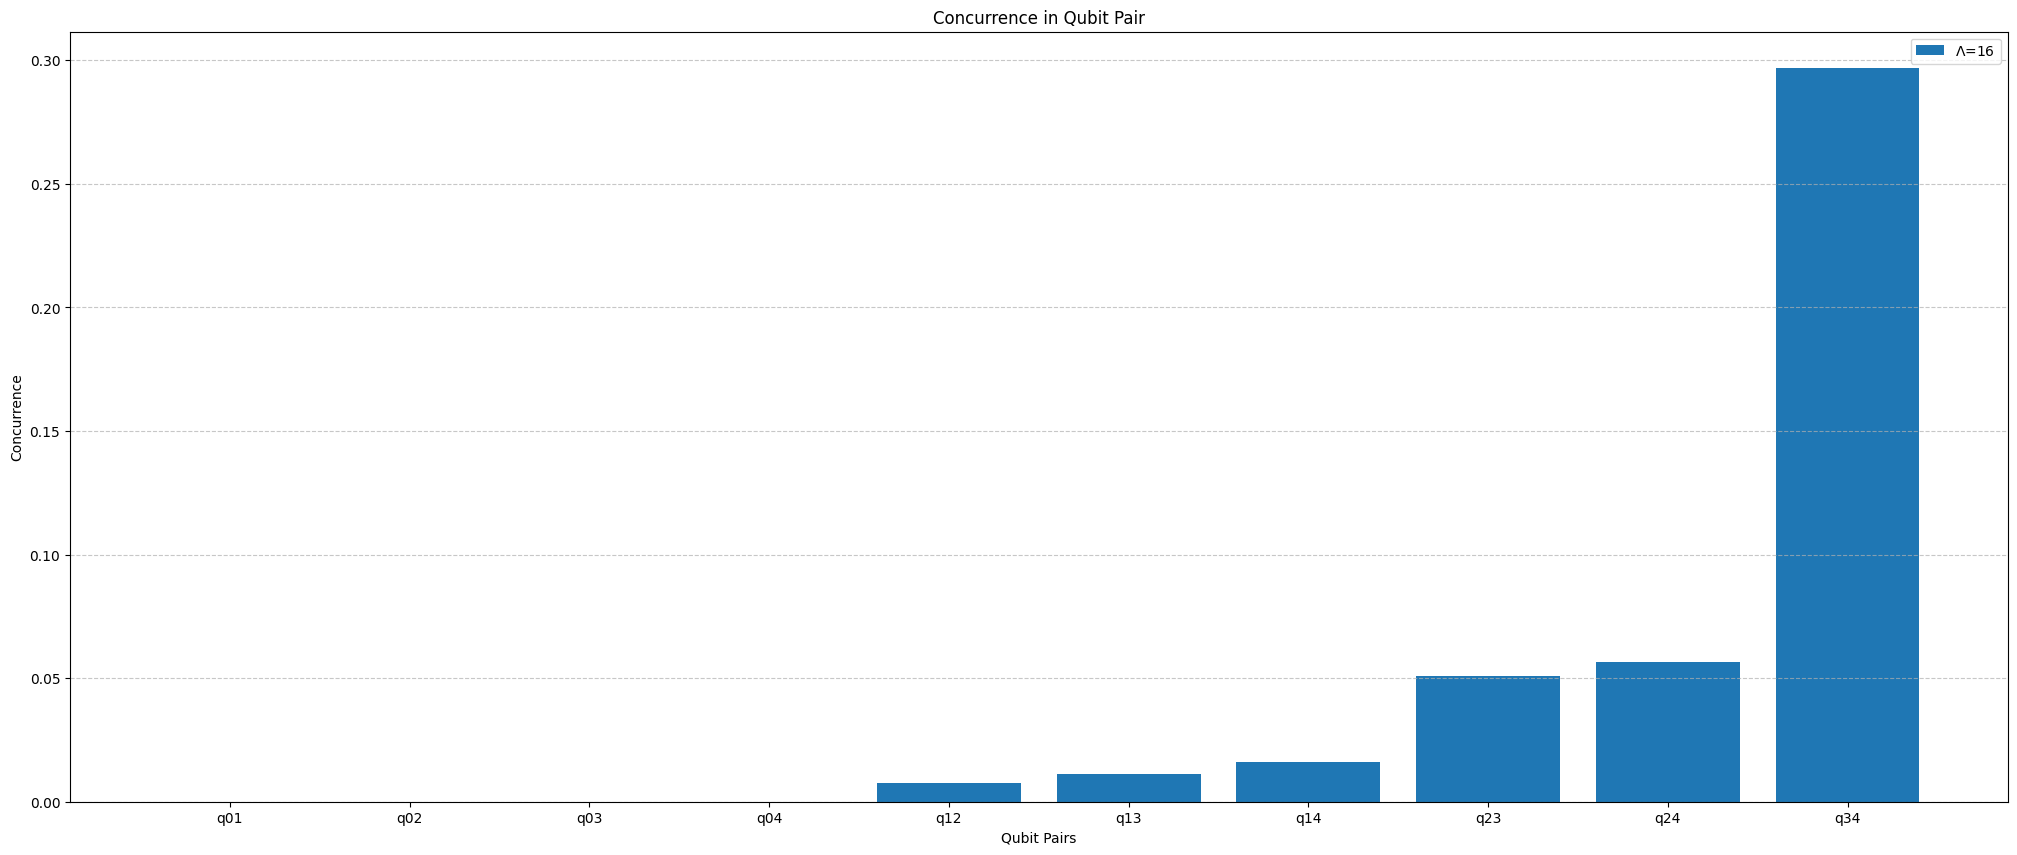

In [3]:
bar_data = data.copy()
cutoffs = bar_data.pop('cutoffs')

qubit_pairs = bar_data.keys()
values = [data[qp] for qp in qubit_pairs]

fig, ax = plt.subplots(figsize=(25,10))

for i, cutoff in enumerate(cutoffs):
    cutoff_values = [v[i] if not np.isnan(v[i]) else 0 for v in values]
    ax.bar(qubit_pairs, cutoff_values, label=f'$\\Lambda$={cutoff}')

ax.set_ylabel('Concurrence')
ax.set_xlabel('Qubit Pairs')
ax.set_title('Concurrence in Qubit Pair')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\ConcurrencePlots\BarPlots\plot_{}".format(potential))

In [2]:
potentials = ['QHO', 'AHO', 'DW']
cutoffs = [4,8,16]

# 9 qubits for 256
data_arr = []

for cutoff in cutoffs:

    all_data = {}

    for potential in potentials:

        data = {}

        data_qu = int(np.log2(max(cutoffs))) + 1
        for qubit1 in range(0, data_qu):
                for qubit2 in range(qubit1 + 1, data_qu):
                        data[f"q{qubit1}{qubit2}"] = []

        #calculate Hamiltonian and expected eigenvalues
        H = calculate_Hamiltonian(cutoff, potential)

        eigenvalues, eigenvectors = np.linalg.eig(H)
        min_index = np.argmin(eigenvalues)
        e_args = np.argsort(eigenvalues)
        min_eigenvalue = eigenvalues[min_index]
        min_eigenvector = np.asarray(eigenvectors[:,e_args[0]])

        hamiltonian = SparsePauliOp.from_operator(H)
        num_qubits = hamiltonian.num_qubits

        psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
        rho = psi * psi.dag()

        cutoff_qubits = []
        for qubit1 in range(1, num_qubits):
            for qubit2 in range(qubit1 + 1, num_qubits):
                
                rho_2q = ptrace(rho, [qubit1, qubit2])
                c = concurrence(rho_2q)

                col_name = f"q{qubit1}{qubit2}"
                data[col_name].append(c)

                cutoff_qubits.append(col_name)

        nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
        for key in nan_qubits:
            data[key].append(np.nan)

        all_data[potential] = data   

    data_arr.append(all_data)      

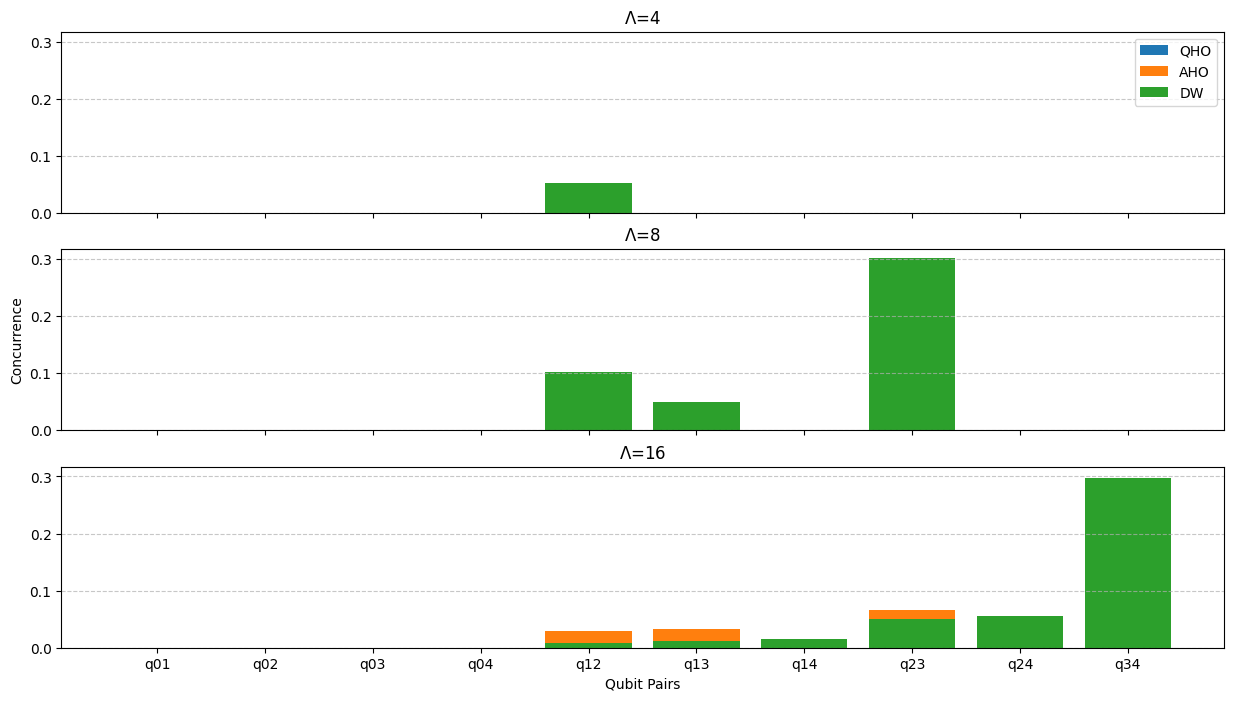

In [55]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharey=True, sharex=True)
#fig, ax = plt.subplots(figsize=(8,4))
for i, data in enumerate(data_arr): 

    for potential in potentials:
        
        bar_data = data[potential]
        qubit_pairs = bar_data.keys()

        values = [bar_data[qp] for qp in qubit_pairs]
        values = [v[0] if not np.isnan(v[0]) else 0 for v in values]
        ax[i].bar(qubit_pairs, values, label=f'{potential}')
        ax[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        ax[i].set_title(f"$\\Lambda$={cutoffs[i]}")

ax[1].set_ylabel('Concurrence')
ax[2].set_xlabel('Qubit Pairs')

ax[0].legend()


plt.show()

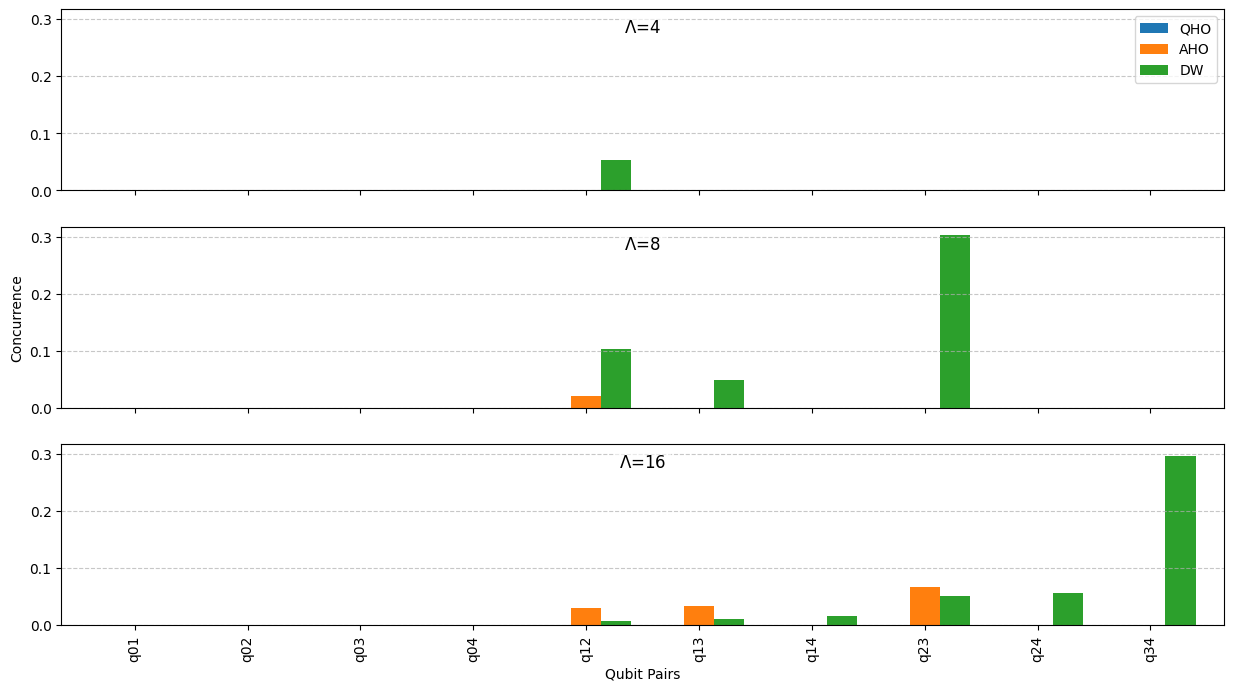

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharey=True, sharex=True)
#fig, ax = plt.subplots(figsize=(8,4))
for i, data in enumerate(data_arr): 

    bar_data=data.copy()
    qubit_pairs = bar_data['QHO'].keys()
        
    data_dict = {
        pot: [
            bar_data[pot][qp][0] if not np.isnan(bar_data[pot][qp][0]) else 0.0
            for qp in qubit_pairs
        ]
        for pot in potentials
    }
    df = pd.DataFrame(data_dict, index=qubit_pairs)

    # Plot grouped bar chart
    df.plot(kind='bar', figsize=(15,8), width=0.8, ax=ax[i])
    ax[i].grid(True, axis='y', linestyle='--', alpha=0.7)
    #ax[i].set_title(f"$\\Lambda$={cutoffs[i]}")
    ax[i].text(
        0.5, 0.95, f"$\\Lambda$={cutoffs[i]}",
        transform=ax[i].transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round')
    )

    if i != 0:
        ax[i].get_legend().remove()

ax[1].set_ylabel('Concurrence')
ax[2].set_xlabel('Qubit Pairs')

#ax[0].legend()

#ax.set_ylabel('Concurrence')
#ax.set_xlabel('Qubit Pairs')
#ax.set_title('Concurrence per Qubit Pair for Each Potential')
#ax.grid(True, axis='y', linestyle='--', alpha=0.7)
#plt.xticks(rotation=45)
#plt.legend(title='Potential')
#plt.tight_layout()
plt.show()

In [ ]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key} ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Concurrence")
plt.title("Concurrence vs. Cutoff for Qubit Pairs")
#plt.legend()
plt.grid()
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\ConcurrencePlots\plot_{}".format(potential))

In [9]:
d = data.copy()
cutoffs = d.pop('cutoffs')
ordered_data = {cutoff: sorted(((k, v[i]) for k, v in d.items()), key=lambda x: (np.isnan(x[1]), -x[1])) for i, cutoff in enumerate(cutoffs)}

df = pd.DataFrame({
    cutoff: [f"{pair[0]} ({pair[1]:.6f})" if not np.isnan(pair[1]) else f"{pair[0]} (nan)" 
             for pair in ordered_data[cutoff]]
    for cutoff in cutoffs
})

In [10]:
df

,2,4,8
0,q12 (nan),q12 (0.052899),q23 (0.302235)
1,q13 (nan),q13 (nan),q12 (0.102541)
2,q23 (nan),q23 (nan),q13 (0.049414)
